# **MC-321 ML :** ASSIGNMENT 8
### **DHARMESH KOTA**
**202203038**

**Importing the necessary libraries**

In [ ]:
!pip3 install -U ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pydotplus
import time
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text, export_graphviz
from ucimlrepo import fetch_ucirepo, list_available_datasets
from IPython.display import Image
from io import StringIO

# **Question 1: Classification**

Consider the CarEvaluation dataset (Available from: [https://archive.ics.uci.edu/dataset/19/car+evaluation](https://archive.ics.uci.edu/dataset/19/car+evaluation)) and implement the following:

- Grow the decision tree using the entropy measure (ID3 algorithm) or gini index (CART algorithm). Decision trees tend to be overly complex and do not generalize well to the data and thus, overfit. To overcome this, stopping criteria can be used such as setting the maximum depth of the tree $T$. Use cross-validation to find the value of depth $T$ that gives the best performance. Plot average accuracy vs. $T$. Visualize the decision tree constructed on the training data.

- **Ensemble methods to overcome overfitting:**
  - **Bagging:** For the value of $T$ identified above, perform bagging using $B$ bootstrapped datasets (You may consider $B$ in the range of 50 to 500 with intervals of 50). Use cross-validation to fix $B$. Plot average accuracy against $B$.
  - **Random forest:** Create a random forest of $B$ trees with the value of $B$ identified above. For each tree, at each terminal node, randomly consider $m$ out of $d$ features (where $m$ can be a value between $\sqrt{d}$ to $d$) for splitting. What is the average accuracy for $m = 4$?
  - Compare and comment on the classification accuracy of the original classification tree, bagged classification tree, and the random forest.

- Use the inbuilt `scikit-learn` implementation for the above experiments.

In [ ]:
car_evaluation = fetch_ucirepo(id=19)

X = car_evaluation.data.features
y = car_evaluation.data.targets

print(car_evaluation.metadata.uci_id)
print(car_evaluation.metadata.num_instances)
print(car_evaluation.metadata.additional_info.summary)

print(car_evaluation.variables)

19
1728
Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates cars according to the following concept structure:

CAR                      car acceptability
. PRICE                  overall price
. . buying               buying price
. . maint                price of the maintenance
. TECH                   technical characteristics
. . COMFORT              comfort
. . . doors              number of doors
. . . persons            capacity in terms of persons to carry
. . . lug_boot           the size of luggage boot
. . safety               estimated safety of the car

Input attributes are printed in lowercase. Besides the target concept (CAR), the model includes three intermediate concepts: PRICE, TECH, COMFORT. Every concept is in the original model related to its lower level descendants by a se

In [ ]:
df = pd.DataFrame(X, columns=car_evaluation.data.feature_names)

label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print("Features (first 5 rows):")
print(df.head())
print("\nEncoded target classes:", le_target.classes_)

Features (first 5 rows):
   buying  maint  doors  persons  lug_boot  safety
0       3      3      0        0         2       1
1       3      3      0        0         2       2
2       3      3      0        0         2       0
3       3      3      0        0         1       1
4       3      3      0        0         1       2

Encoded target classes: ['acc' 'good' 'unacc' 'vgood']


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
param_grid = {'max_depth': np.arange(1, 21)}

tree = DecisionTreeClassifier(criterion='gini', random_state=38)

grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(df, y_encoded)

best_T = grid_search.best_params_['max_depth']
print("Best max_depth (T):", best_T)

Best max_depth (T): 8


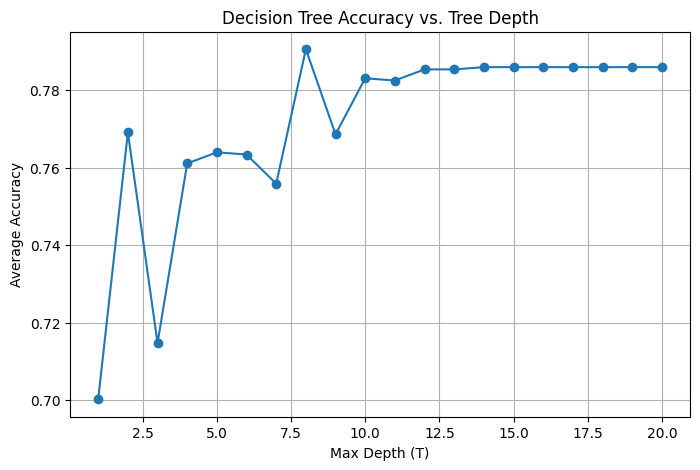

In [ ]:
mean_scores = grid_search.cv_results_['mean_test_score']
depths = np.arange(1, 21)

plt.figure(figsize=(8, 5))
plt.plot(depths, mean_scores, marker='o')
plt.xlabel('Max Depth (T)')
plt.ylabel('Average Accuracy')
plt.title('Decision Tree Accuracy vs. Tree Depth')
plt.grid(True)
plt.show()

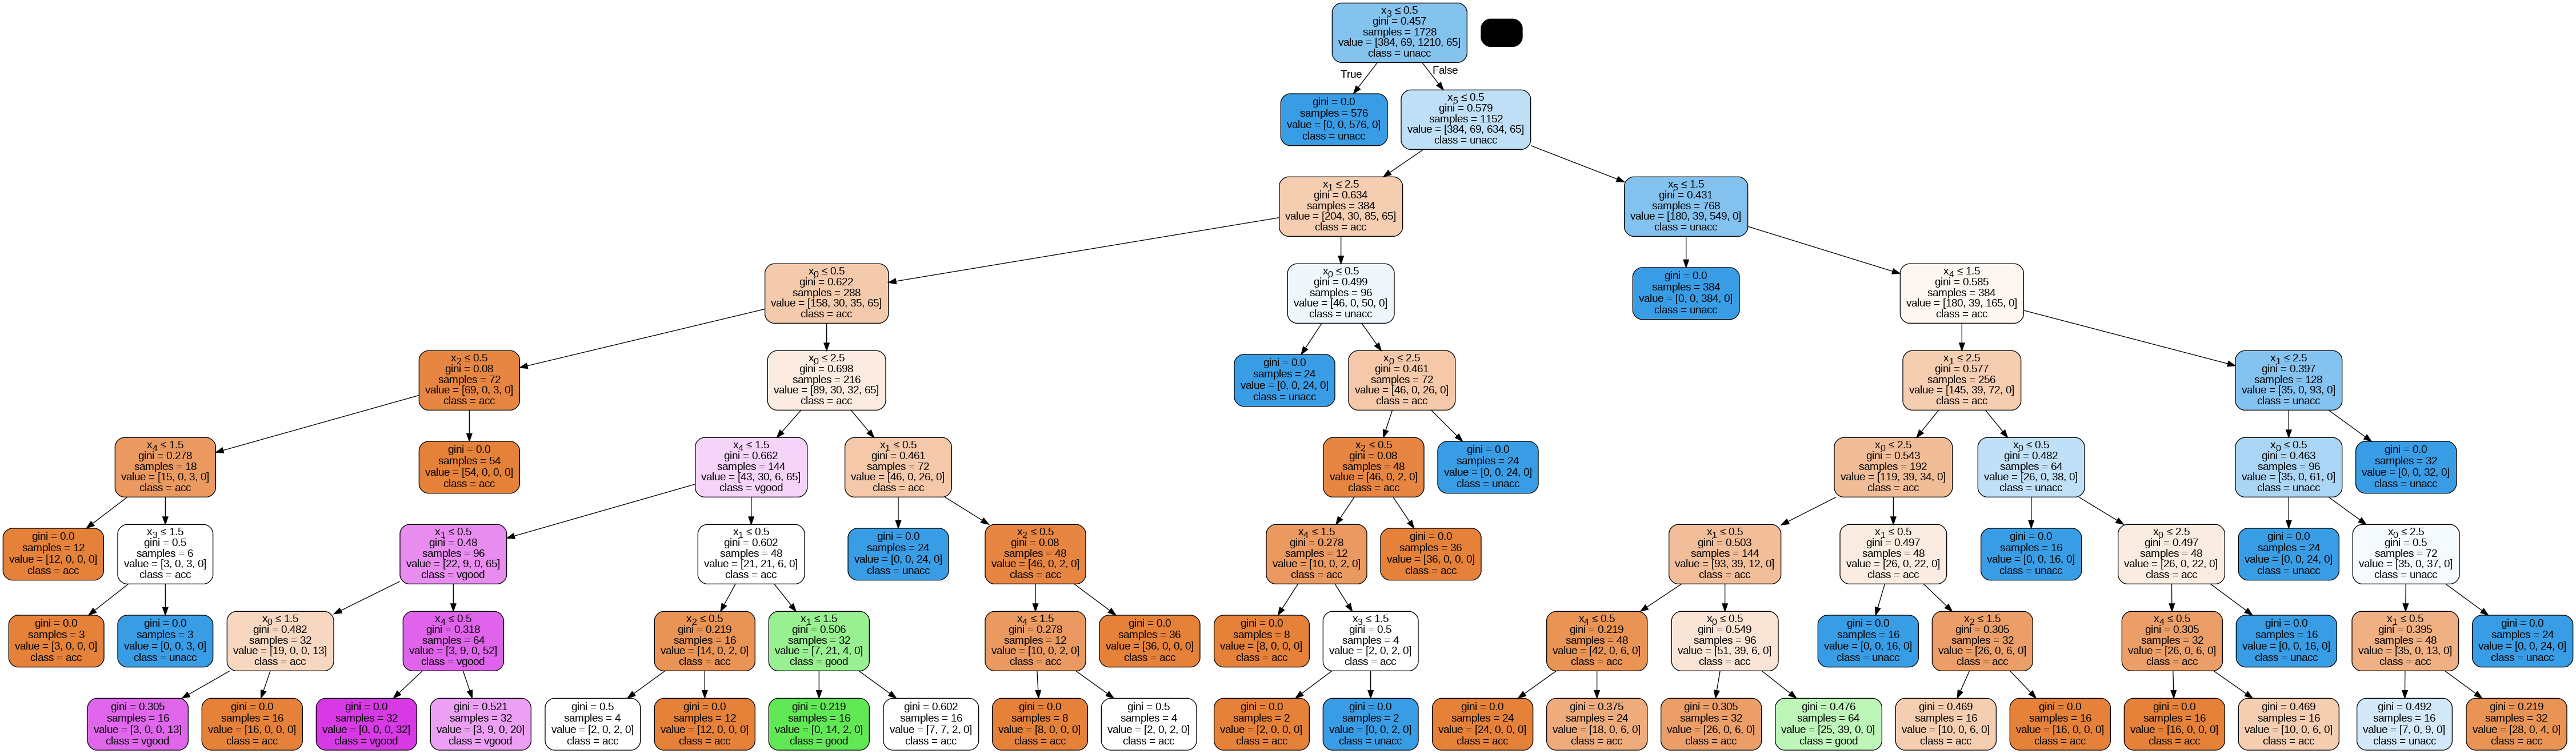

In [ ]:
best_tree = grid_search.best_estimator_

dot_data = StringIO()
export_graphviz(best_tree, out_file=dot_data,
                feature_names=car_evaluation.data.feature_names,
                class_names=le_target.classes_.astype(str),
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## **Ensemble methods to overcome overfitting**
### **1. BAGGING**

B = 50, Average Accuracy = 0.7761
B = 100, Average Accuracy = 0.7686
B = 150, Average Accuracy = 0.7697
B = 200, Average Accuracy = 0.7715
B = 250, Average Accuracy = 0.7749
B = 300, Average Accuracy = 0.7726
B = 350, Average Accuracy = 0.7732
B = 400, Average Accuracy = 0.7755
B = 450, Average Accuracy = 0.7755
B = 500, Average Accuracy = 0.7738


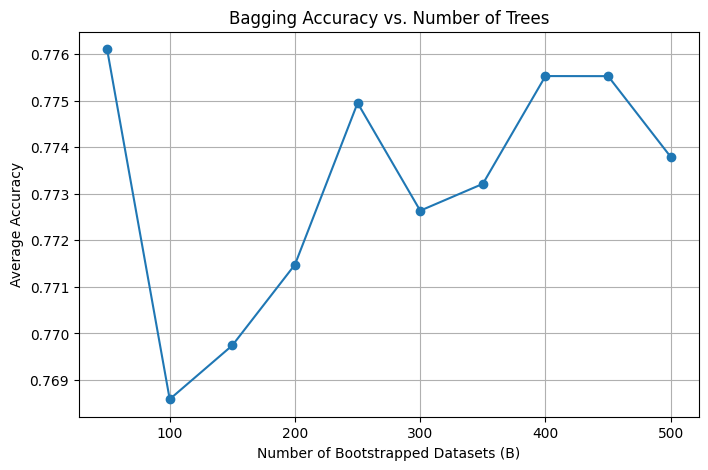

In [ ]:
B_values = range(50, 501, 50)
bagging_scores = []

for B in B_values:
    bagging = BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=best_T, random_state=38),
        n_estimators=B,
        random_state=38
    )
    scores = cross_val_score(bagging, df, y_encoded, cv=5, scoring='accuracy')
    mean_score = np.mean(scores)
    bagging_scores.append(mean_score)
    print(f"B = {B}, Average Accuracy = {mean_score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(list(B_values), bagging_scores, marker='o')
plt.xlabel('Number of Bootstrapped Datasets (B)')
plt.ylabel('Average Accuracy')
plt.title('Bagging Accuracy vs. Number of Trees')
plt.grid(True)
plt.show()

### **2. RANDOM FORESTS**

In [ ]:
best_B = 50

rf = RandomForestClassifier(
    n_estimators=best_B,
    max_features=4,
    max_depth=best_T,
    random_state=38
)

rf_scores = cross_val_score(rf, df, y_encoded, cv=5, scoring='accuracy')
print("Random Forest average accuracy (m=4):", np.mean(rf_scores))

Random Forest average accuracy (m=4): 0.8027243025885902


### **Bagging Results**

- Bagging accuracy showed slight variation as the number of trees ($B$) increased.
- Accuracy ranged between **76.86% and 77.61%**.
- The highest accuracy of **77.61%** was achieved when **$B = 50$**.

### **Random Forest Results**

- The Random Forest model builds multiple trees and, at each split, randomly selects **4 features** out of all available ones.
- It achieved a higher average accuracy of around **80.27%**.

### **Comparison and Conclusion**

- **Bagging** helps reduce overfitting by averaging multiple decision trees trained on different bootstrapped datasets. The accuracy improvement was small but consistent.
- **Random Forest** builds on bagging by also introducing randomness in feature selection, which further improves generalization.
- **Overall**, the **Random Forest model outperformed** the Bagging model on this dataset, offering better accuracy and robustness.


# **Question 2: Regression**

Consider the Boston Housing dataset ([http://lib.stat.cmu.edu/datasets/boston](http://lib.stat.cmu.edu/datasets/boston)). Perform decision tree regression to predict the value of **MEDV**, which represents the median price of owner-occupied homes.

- **Grow a regression tree** using recursive binary splitting.
  - Decision trees can overfit and may not generalize well to new data.
  - To reduce overfitting, use stopping criteria such as limiting the **maximum depth** or setting a **minimum number of samples** in the terminal node.
  - Use **$S = 4$** (minimum samples per leaf).
  - Visualize the regression tree built on the training data.

- **Ensemble methods to overcome overfitting:**
  - **Bagging:**
    - Use the value of $S$ identified above.
    - Perform bagging with $B$ bootstrapped datasets ($B$ from 50 to 500 in steps of 50).
    - Use cross-validation to select the best $B$.
    - Plot **average mean squared error (MSE)** against $B$.
  
  - **Random Forest:**
    - Build a random forest with the chosen value of $B$.
    - At each terminal node, randomly consider $m$ out of $d$ features for splitting (where $m$ is between $\sqrt{d}$ and $d$).
    - Report the average prediction accuracy for **$m = 7$**.

- **Compare the prediction variance** for:
  - The original regression tree
  - The bagged regression tree
  - The random forest

- **Plot regression curves**:
  - **MEDV vs. CRIM** (per capita crime rate by town)
  - **MEDV vs. INDUS** (proportion of non-retail business acres per town)
  - **MEDV vs. AGE** (proportion of owner-occupied units built prior to 1940)

- Use the inbuilt `scikit-learn` implementation for all the above experiments.

In [ ]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

X = df.drop("medv", axis=1)
y = df["medv"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

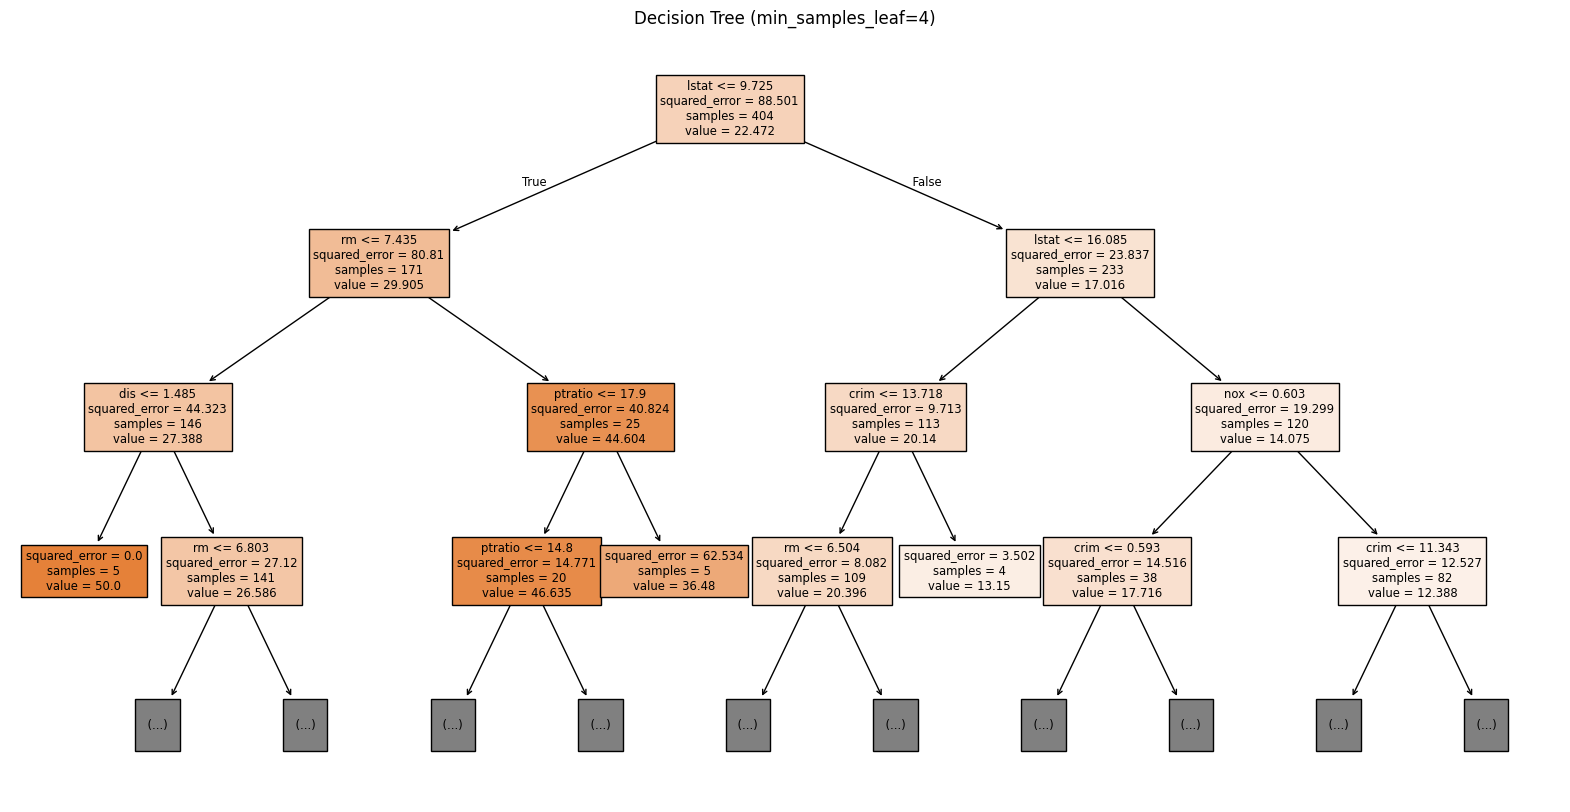

In [ ]:
tree = DecisionTreeRegressor(min_samples_leaf=4, random_state=38)
tree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, filled=True, max_depth=3)
plt.title("Decision Tree (min_samples_leaf=4)")
plt.show()

### **BAGGING**

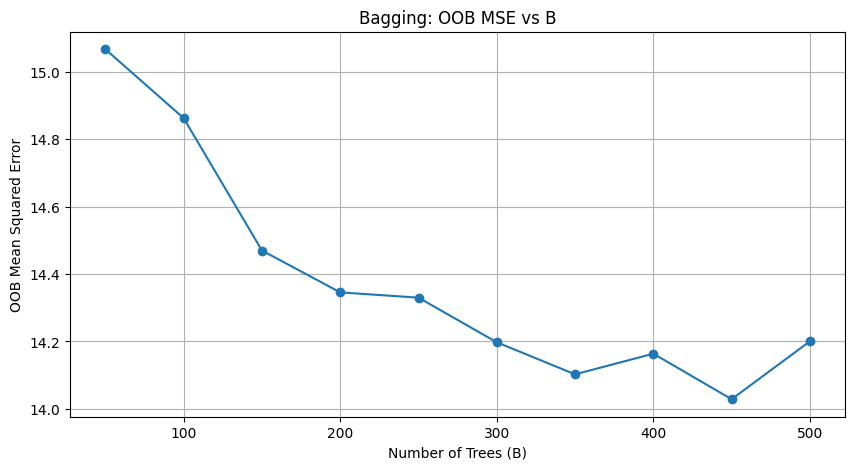

Best B value: 450


In [ ]:
B_values = list(range(50, 501, 50))
mse_values = []

for B in B_values:
    bag = BaggingRegressor(
        estimator=DecisionTreeRegressor(min_samples_leaf=4),
        n_estimators=B,
        random_state=38,
        oob_score=True,
        bootstrap=True
    )
    bag.fit(X_train, y_train)
    oob_mse = mean_squared_error(y_train, bag.oob_prediction_)
    mse_values.append(oob_mse)

plt.figure(figsize=(10, 5))
plt.plot(B_values, mse_values, marker='o')
plt.xlabel("Number of Trees (B)")
plt.ylabel("OOB Mean Squared Error")
plt.title("Bagging: OOB MSE vs B")
plt.grid(True)
plt.show()

best_B = B_values[np.argmin(mse_values)]
print("Best B value:", best_B)

### **RANDOM FOREST**

In [ ]:
rf = RandomForestRegressor(
    n_estimators=best_B,
    max_features=7,
    min_samples_leaf=4,
    random_state=38
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
print("Random Forest MSE (m=7):", mse_rf)

Random Forest MSE (m=7): 6.393486780885489


### **COMPARISION**

In [ ]:
tree_preds = tree.predict(X_test)

bag_preds = bag.predict(X_test)

rf_preds = rf.predict(X_test)

print("Prediction Variance:")
print("Decision Tree:", np.var(tree_preds))
print("Bagging:", np.var(bag_preds))
print("Random Forest:", np.var(rf_preds))

Prediction Variance:
Decision Tree: 60.84778689445822
Bagging: 54.664000745271274
Random Forest: 50.87827422476405


### **MEDV vs. CRIM**, **MEDV vs. INDUS** and **MEDV vs. AGE**

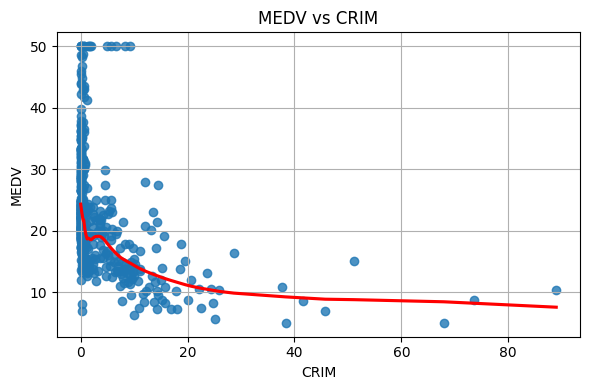

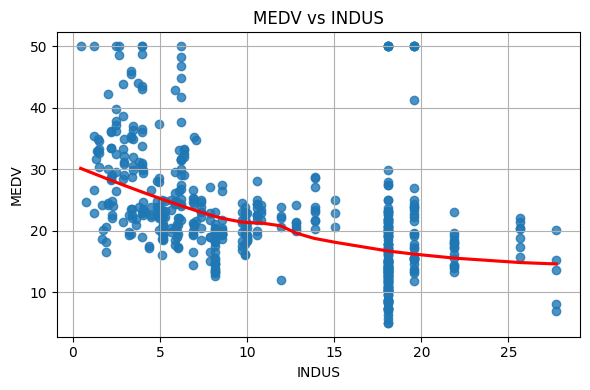

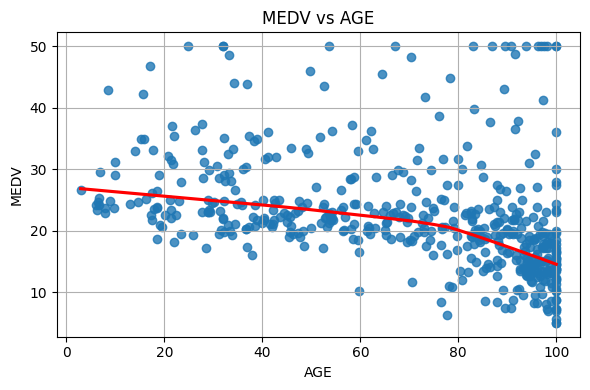

In [ ]:
features = ["crim", "indus", "age"]
for feat in features:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=df[feat], y=df["medv"], lowess=True, line_kws={"color": "red"})
    plt.title(f"MEDV vs {feat.upper()}")
    plt.xlabel(feat.upper())
    plt.ylabel("MEDV")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print()


# **Question 3: Boosting & Comparative Analysis**

## **Part A: Boosting Implementation**

### **Classification (CarEvaluation)**
- Implement **AdaBoost** with **decision stumps** (i.e., trees with `max_depth = 1`).
- Use **cross-validation** to tune the number of estimators $N$.
- Plot **accuracy vs. $N$**.
- **Visualize feature importance** and compare it with the feature importance obtained from the Random Forest model in Question 1.

### **Regression (Boston Housing)**
- Implement **Gradient Boosting Regression Trees (GBRT)**.
- Tune the **learning rate** $\eta \in \{0.01, 0.1, 0.5\}$ and the **number of estimators** $N$ using **cross-validation**.
- Plot **Mean Squared Error (MSE) vs. $N$** for each value of $\eta$.

### **CLASSIFICATION (CAR EVALUATION)**

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
df_car = pd.read_csv(url, header=None)
df_car.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

le = LabelEncoder()
for col in df_car.columns:
    df_car[col] = le.fit_transform(df_car[col])

X_car = df_car.drop('class', axis=1)
y_car = df_car['class']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_car, y_car, test_size=0.2, random_state=38)

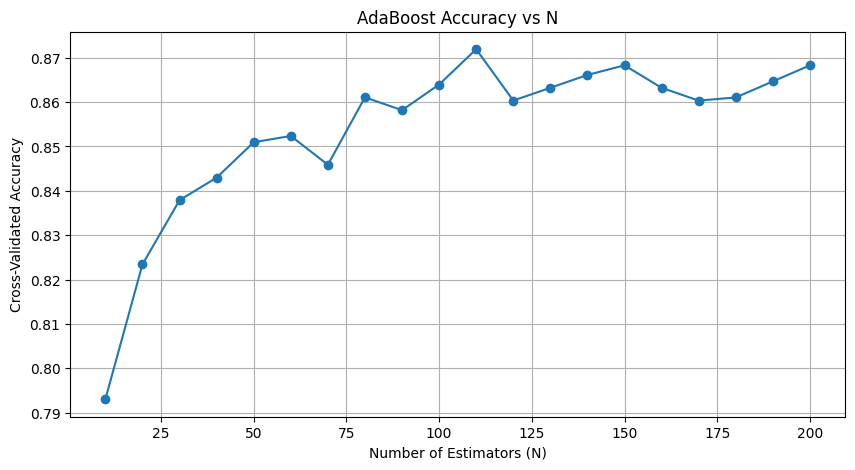

Best N for AdaBoost (Classification): 110


In [ ]:
N_values = list(range(10, 201, 10))
acc_scores = []

for N in N_values:
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=N,
        random_state=38
    )
    scores = cross_val_score(ada, Xc_train, yc_train, cv=5, scoring='accuracy')
    acc_scores.append(scores.mean())

plt.figure(figsize=(10, 5))
plt.plot(N_values, acc_scores, marker='o')
plt.xlabel("Number of Estimators (N)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("AdaBoost Accuracy vs N")
plt.grid(True)
plt.show()

best_N_cls = N_values[np.argmax(acc_scores)]
print("Best N for AdaBoost (Classification):", best_N_cls)

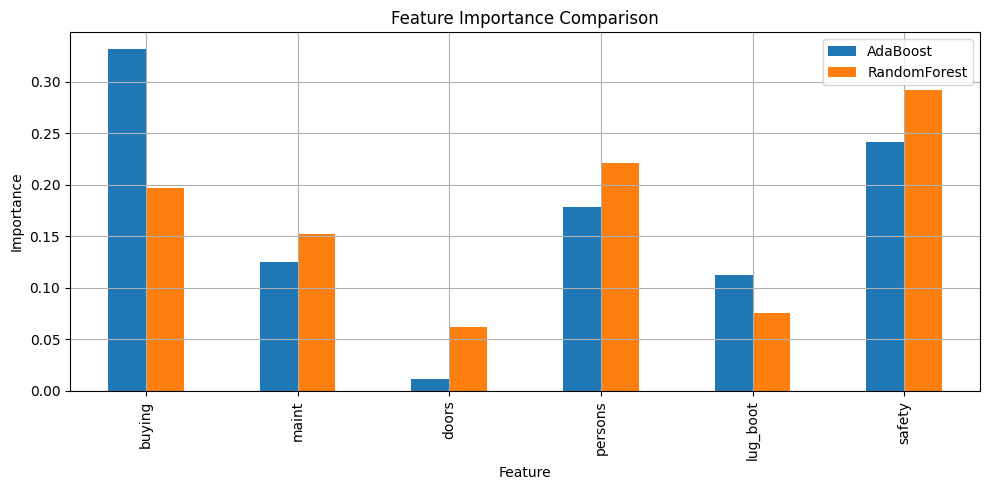

In [ ]:
best_ada = AdaBoostClassifier(
   estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_N_cls,
    random_state=38
).fit(Xc_train, yc_train)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=38).fit(Xc_train, yc_train)

feat_names = X_car.columns
ada_imp = best_ada.feature_importances_
rf_imp = rf_clf.feature_importances_

imp_df = pd.DataFrame({
    "Feature": feat_names,
    "AdaBoost": ada_imp,
    "RandomForest": rf_imp
}).set_index("Feature")

imp_df.plot(kind="bar", figsize=(10, 5))
plt.title("Feature Importance Comparison")
plt.ylabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

### **REGRESSION (BOSTON HOUSING)**

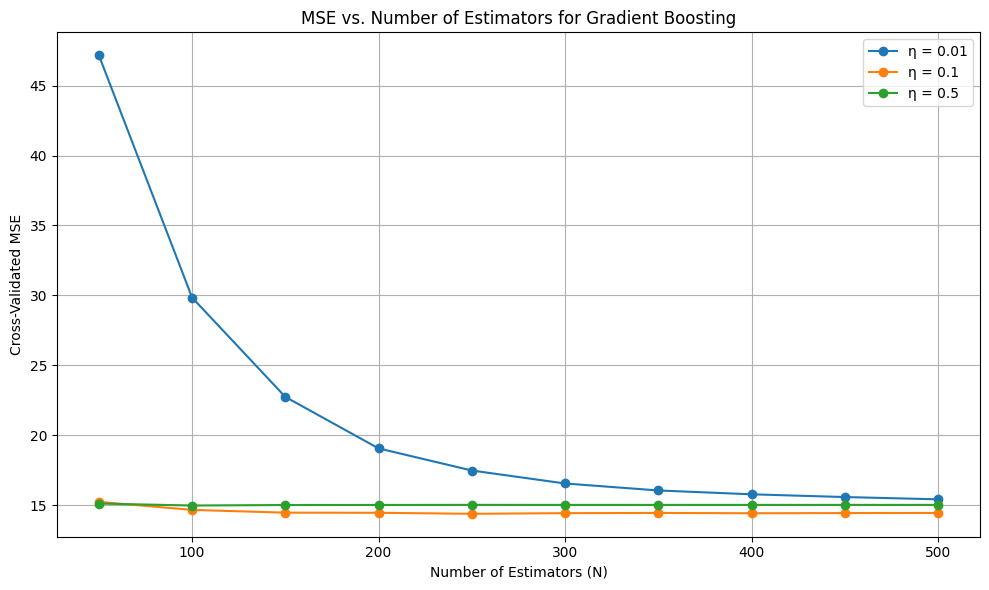

In [ ]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

X = df.drop("medv", axis=1)
y = df["medv"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

learning_rates = [0.01, 0.1, 0.5]
n_estimators_range = range(50, 501, 50)

results = {}

for eta in learning_rates:
    mse_list = []
    for n in n_estimators_range:
        model = GradientBoostingRegressor(n_estimators=n, learning_rate=eta, random_state=38)
        mse = -np.mean(cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
        mse_list.append(mse)
    results[eta] = mse_list

plt.figure(figsize=(10, 6))
for eta in learning_rates:
    plt.plot(n_estimators_range, results[eta], marker='o', label=f'η = {eta}')
plt.title("MSE vs. Number of Estimators for Gradient Boosting")
plt.xlabel("Number of Estimators (N)")
plt.ylabel("Cross-Validated MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Part B: Comparative Analysis**

### **Compare the following methods:**
- **Pruned Decision Tree** (tune `max_depth` or `min_samples_leaf`)
- **Bagging** (using optimal $B$ from Questions 1/2)
- **Boosting** (AdaBoost for classification / GBRT for regression)

### **Create a summary table:**

| Method         | Test Accuracy / MSE | Training Time (s) | Prediction Variance |
|----------------|---------------------|--------------------|----------------------|
| Pruned Tree    |                     |                    |                      |
| Bagging        |                     |                    |                      |
| Boosting       |                     |                    |                      |

### **Discussion:**
- Which method generalizes best for each dataset?
- When might you prefer **pruning** over **ensemble methods**? Consider:
  - Dataset size
  - Amount of noise
  - Interpretability

> Use the inbuilt `scikit-learn` implementation for all the above experiments.

In [ ]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

X = df.drop("medv", axis=1)
y = df["medv"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
results = []

# 1. Pruned Decision Tree
start = time.time()
dt = DecisionTreeRegressor(min_samples_leaf=4, random_state=38)
dt.fit(X_train, y_train)
train_time = time.time() - start
y_pred = dt.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
variance = np.var(y_pred)
results.append(["Pruned Tree", mse, train_time, variance])

# 2. Bagging Regressor (B=450)
start = time.time()
bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(min_samples_leaf=4),
    n_estimators=450, random_state=38)
bag.fit(X_train, y_train)
train_time = time.time() - start
y_pred = bag.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
variance = np.var(y_pred)
results.append(["Bagging (B=450)", mse, train_time, variance])

# 3. Gradient Boosting (η=0.1, N=200)
start = time.time()
gbrt = GradientBoostingRegressor(
    learning_rate=0.1, n_estimators=200,
    min_samples_leaf=4, random_state=38)
gbrt.fit(X_train, y_train)
train_time = time.time() - start
y_pred = gbrt.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
variance = np.var(y_pred)
results.append(["Boosting (η=0.1, N=200)", mse, train_time, variance])

In [ ]:
summary = pd.DataFrame(results, columns=["Method", "Test MSE", "Training Time (s)", "Prediction Variance"])
summary


,Method,Test MSE,Training Time (s),Prediction Variance
0,Pruned Tree,12.026486,0.007944,60.184930
1,Bagging (B=450),11.338835,1.814346,56.616821
2,"Boosting (η=0.1, N=200)",6.522048,0.446671,66.312551


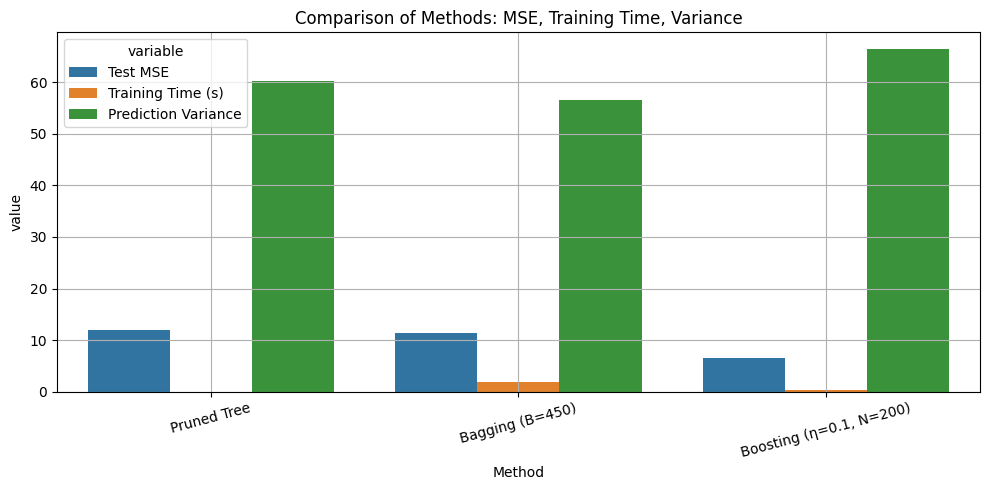

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=summary.melt(id_vars="Method"), x="Method", y="value", hue="variable")
plt.title("Comparison of Methods: MSE, Training Time, Variance")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()